In [2]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

#this code below is to make %%time magic work
import glob
import os
from __future__ import print_function
#this code above is to make %%time magic work

In [3]:
#import the data
directory = 'C:/Users/N1110/Desktop/7331_Project/data/'
df = pd.read_csv(directory + 'Diabetes_tmp_Cleaned.csv')
df_clean = df
df_clean.replace('?', np.nan, inplace=True)

In [4]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 51 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
number_diagnoses            101766 non-null int64
max_glu_serum               101766 

In [5]:
#can also use binary encoder to achieve this
df_clean.gender[df_clean.gender == 'Male'] = 0
df_clean.gender[df_clean.gender == 'Female'] = 1

df_clean["gender"] = df_clean["gender"].astype(int)

In [6]:
#10 age groups; Ordinal encoding
#feature density plot of age can help with answering the question like: does people older age tend to be readmitted?
#can use map/apply function to achieve this

df_clean.age[df_clean.age== '[0-10)'] = 1
df_clean.age[df_clean.age== '[10-20)'] = 2
df_clean.age[df_clean.age== '[20-30)'] = 3
df_clean.age[df_clean.age== '[30-40)'] = 4
df_clean.age[df_clean.age== '[40-50)'] = 5
df_clean.age[df_clean.age== '[50-60)'] = 6
df_clean.age[df_clean.age== '[60-70)'] = 7
df_clean.age[df_clean.age== '[70-80)'] = 8
df_clean.age[df_clean.age== '[80-90)'] = 9
df_clean.age[df_clean.age== '[90-100)'] = 10

df_clean["age"] = df_clean["age"].astype(int)

In [7]:
#one hot encoding categorical variables

#FE based on Feature Importance plot from LR model

#add more important features: discharge_disposition_id, admission_source_id. I think they should be categorical, so I put them in dummy list
#also include all medications

dummiesList=["diag_1_val","diag_2_val","diag_3_val","race","A1Cresult","admission_type","admission_source","discharge_disposition",
             "meds_increased","diabetesMed","medical_specialty", "max_glu_serum", "meds_increased", "insulin",
            "metformin", "repaglinide", "nateglinide", "chlorpropamide",
             "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             "tolazamide", "glyburide-metformin", "glipizide-metformin",
             "metformin-rosiglitazone", "metformin-pioglitazone"]
df_clean_wDummies = pd.get_dummies(df_clean[dummiesList])

In [8]:
#combine with numerical features we decide to use and target readmitted_tf
NumFeatures=["num_lab_procedures","num_procedures","number_outpatient","number_emergency", "number_inpatient","num_medications",
             "medication_count","number_diagnoses", "gender","age","readmitted_tf"]
df_clean_wDummies= pd.concat((df_clean_wDummies, df_clean[NumFeatures]), axis=1)

In [9]:
df_clean_wDummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Columns: 245 entries, meds_increased to readmitted_tf
dtypes: int32(2), int64(11), uint8(232)
memory usage: 31.8 MB


In [10]:
df_imputed=df_clean_wDummies


from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'readmitted_tf' in df_imputed:
    y = df_imputed['readmitted_tf'].values # get the labels we want
    del df_imputed['readmitted_tf'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [11]:
## Training and Testing Split
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

In [12]:
    # we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(X_train)
X_test_scaled = scl_obj.transform(X_test)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
# lets investigate SVMs on the data and play with the parameters and kernels
#%%time
#try run with all medications

from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

In [24]:
#get SVM ACC

from sklearn import metrics as mt

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)

print('SVM accuracy:', acc )
print(conf)

# SVM accuracy: 0.6815859290557139
#acc is lower compare with svm model without med accuracy: 0.6822246241525007
#run longer than svm model without med
#but decide to keep these bc RF does not require the assumption of multicolinearity

SVM accuracy: 0.6815859290557139
[[9512 1464]
 [5017 4361]]


In [25]:
#wrong
#get SVM AUC
#roc = roc_auc_score(y_test, svm_clf.predict_proba(X_test_scaled)[:,1])
#print('SVM AUC:', roc )

AttributeError: predict_proba is not available when  probability=False

In [26]:
#get SVM AUC
roc = roc_auc_score(y_test,y_hat)
print('SVM AUC:', roc )

#SVM AUC: 0.6658213006434637

SVM AUC: 0.6658213006434637


In [28]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

y_hat_probs = svm_clf.predict_proba(X_test)
y_hat = np.where(y_hat_probs >= cutoff, 1, 0)
y_hat = y_hat[:,1]
    
rocCurvePlot(y_hat_probs, y_test)

AttributeError: predict_proba is not available when  probability=False

In [13]:
#SVM_SGD

#SGD made SVM model train fast. this was done in seconds comparing with no SGD 14 mins run.
from sklearn.model_selection import StratifiedShuffleSplit 
from sklearn import metrics as mt
cv = StratifiedShuffleSplit( n_splits=1,test_size=0.5)
# use some compact notation for creating a linear SVM classifier with stichastic descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('SVM_SGD:', acc)

# For Dummlist
#dummiesList=["diag_1_val","diag_2_val","diag_3_val","race","A1Cresult","admission_type","admission_source","discharge_disposition",
             #"metformin", "repaglinide", "nateglinide", "chlorpropamide",
             #"glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             # "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             #"tolazamide", "insulin", "glyburide-metformin", "glipizide-metformin",
             #"metformin-rosiglitazone", "metformin-pioglitazone"]
#SVM_SGD: 0.6552679676905843 comparing without medications(only insulin included model) which had SVM_SGD: 0.655405538195468
#only a slight increase so not worth including all medications for SVM



C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SVM_SGD: 0.6600043236444392


C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


#dummiesList=["diag_1_val","diag_2_val","diag_3_val","race","A1Cresult","admission_type","admission_source","discharge_disposition",
             "meds_increased","diabetesMed","medical_specialty", "max_glu_serum", "meds_increased",
             "metformin", "repaglinide", "nateglinide", "chlorpropamide",
             "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
             "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
             "tolazamide", "insulin", "glyburide-metformin", "glipizide-metformin",
             "metformin-rosiglitazone", "metformin-pioglitazone"]
                
#combine with numerical features we decide to use and target readmitted_tf
NumFeatures=["num_lab_procedures","num_procedures","number_outpatient","number_emergency", "number_inpatient","num_medications",
             "medication_count","number_diagnoses", "gender","age","readmitted_tf"]
df_clean_wDummies= pd.concat((df_clean_wDummies, df_clean[NumFeatures]), axis=1)                

#SVM_SGD: 0.6608690525322799
increased a little bit with more features.


no medication except insulin

SVM_SGD: 0.6600436295029775



In [93]:
#first try, no optimized parameters. do not use
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier( criterion = 'gini', 
                                n_estimators = 5, verbose = False)
rf_clf.fit(X_train_scaled,y_train)

preds = rf_clf.predict(X_test_scaled)
    
    
print('Random Forest - roc_auc_score: ', roc_auc_score(y_test, preds))

# Random Forest - roc_auc_score:  0.6324899400482888

Random Forest - roc_auc_score:  0.626858813237543


##RF
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=False,
            warm_start=False)

In [14]:
#run for 2 mins
NUM_ESTIMATORS = 100
NO_JOBS = 4
RANDOM_STATE = 2000        
        
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(  random_state = RANDOM_STATE, criterion = 'gini', 
                                n_estimators = NUM_ESTIMATORS, verbose = False)
rf_clf.fit(X_train_scaled,y_train)

preds = rf_clf.predict(X_test_scaled)
print('Random Forest - roc_auc_score: ', roc_auc_score(y_test, preds)) 

# Random Forest - roc_auc_score:  0.6708529023107371

# Random Forest - roc_auc_score:  0.6745548227288356

Random Forest - roc_auc_score:  0.6745548227288356


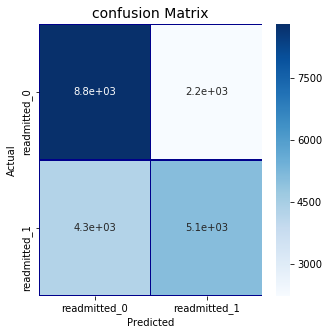

In [95]:
#Confusion Matrix
cm = pd.crosstab(y_test, preds, rownames = ['Actual'], colnames = ['Predicted'])
fig, (ax1) = plt.subplots(ncols = 1, figsize = (5, 5))
sns.heatmap(cm, xticklabels = ['readmitted_0', 'readmitted_1'], yticklabels = ['readmitted_0', 'readmitted_1'], 
            annot = True, ax = ax1,
            linewidths = .2, linecolor = 'Darkblue', cmap ='Blues')
plt.title('confusion Matrix', fontsize = 14)
plt.show()

In [96]:
rf_clf.feature_importances_

array([4.03832872e-03, 3.67430317e-03, 1.23185328e-02, 6.60332777e-03,
       7.65750458e-03, 5.37814102e-03, 6.05754745e-03, 4.08908968e-03,
       9.30376862e-03, 2.75525305e-05, 6.37524721e-03, 9.36047324e-03,
       1.33903457e-02, 8.38167593e-03, 4.63664406e-03, 7.44555264e-03,
       2.93841509e-03, 2.29828345e-03, 1.11432596e-02, 3.89687986e-04,
       7.83729076e-03, 8.66797011e-03, 1.36687714e-02, 1.02533602e-02,
       4.79097372e-03, 6.56136732e-03, 2.63615022e-03, 2.56424748e-03,
       1.11517302e-02, 1.27159825e-03, 9.65654301e-03, 7.12714922e-03,
       9.61077359e-03, 9.46533980e-04, 1.06907506e-02, 2.46478577e-03,
       1.97332880e-03, 2.52502410e-03, 3.93810293e-03, 5.90437644e-03,
       8.97944186e-03, 4.81814061e-03, 9.12878430e-03, 9.00758241e-03,
       7.01210167e-03, 3.04419967e-03, 3.11926059e-04, 1.00818586e-02,
       7.48310255e-03, 1.00938537e-02, 1.08777461e-05, 8.76849500e-03,
       1.22343025e-06, 3.37472191e-04, 1.36583720e-04, 3.48346913e-04,
      

In [81]:
# Feature Importance
tmp = pd.DataFrame({'Feature' : predictors, 'Feature importance' : rf_clf.feature_importances_})
tmp = tmp.sort_values(by = 'Feature importance', ascending = False)
plt.figure(figsize = (7, 4))
plt.title('Feature Importance', fontsize = 14)
s = sns.barplot(x = 'Feature', y = 'Feature importance', data = tmp)
s.set_xticklabels(s.get_xticklabels(), rotation = 90)
plt.show()

ValueError: arrays must all be same length

In [80]:
predictors = ["num_lab_procedures","num_procedures","number_outpatient","number_emergency", "number_inpatient","num_medications",
             "medication_count","number_diagnoses", "gender","age"]

In [15]:
import xgboost as xgb


#XGBOOST
MAX_ROUNDS = 1000
EARLY_STOP = 50
OPT_ROUNDS = 1000
VERBOSE_EVAL = 50

# XGBoost
dtrain = xgb.DMatrix(X_train_scaled, y_train)
dvalid = xgb.DMatrix(X_test_scaled, y_test)
type(dtrain)

xgboost.core.DMatrix

In [16]:
# XGBoost Parameters
params = {}
params['objective'] = 'binary:logistic'
#params['objective'] = 'multi:softmax'
#params['objective'] = 'reg:linear'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [17]:
xgb_clf = xgb.train(params,
                   dtrain,
                   MAX_ROUNDS,
                   watchlist,
                   early_stopping_rounds = EARLY_STOP,
                   maximize = True,
                   verbose_eval = VERBOSE_EVAL)

[0]	train-auc:0.628738	valid-auc:0.632381
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.713596	valid-auc:0.714809
[100]	train-auc:0.723154	valid-auc:0.723677
[150]	train-auc:0.730313	valid-auc:0.730179
[200]	train-auc:0.734796	valid-auc:0.734343
[250]	train-auc:0.737534	valid-auc:0.736758
[300]	train-auc:0.740371	valid-auc:0.739263
[350]	train-auc:0.742701	valid-auc:0.741329
[400]	train-auc:0.744322	valid-auc:0.74287
[450]	train-auc:0.746178	valid-auc:0.744448
[500]	train-auc:0.747637	valid-auc:0.745587
[550]	train-auc:0.748767	valid-auc:0.746554
[600]	train-auc:0.749989	valid-auc:0.747433
[650]	train-auc:0.750924	valid-auc:0.748119
[700]	train-auc:0.751813	valid-auc:0.748864
[750]	train-auc:0.75263	valid-auc:0.749431
[800]	train-auc:0.75341	valid-auc:0.750107
[850]	train-auc:0.754086	valid-auc:0.750557
[900]	train-auc:0.754666	valid-auc:0.750913
[950]	train-auc:0.75539	val

In [19]:
preds = xgb_clf.predict(dvalid)
print('XGBoost - roc_auc_score: ', roc_auc_score(y_test, preds))

#XGBoost - roc_auc_score:  0.7516461447594301

XGBoost - roc_auc_score:  0.7516461447594301


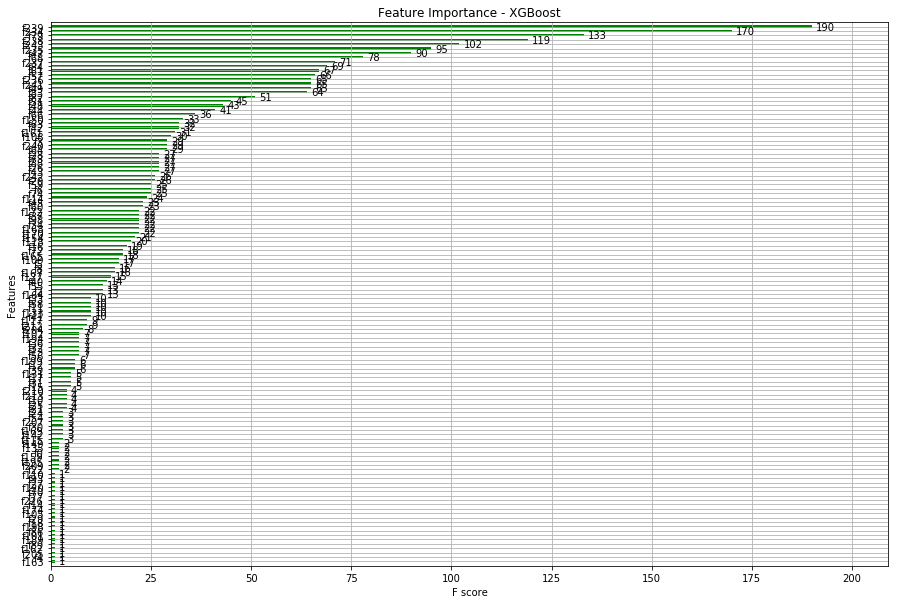

In [22]:
fig, ax = plt.subplots(ncols = 1, figsize = (15, 10))
xgb.plot_importance(xgb_clf, height = 0.5, title = 'Feature Importance - XGBoost', ax = ax, color = 'green')
plt.show()

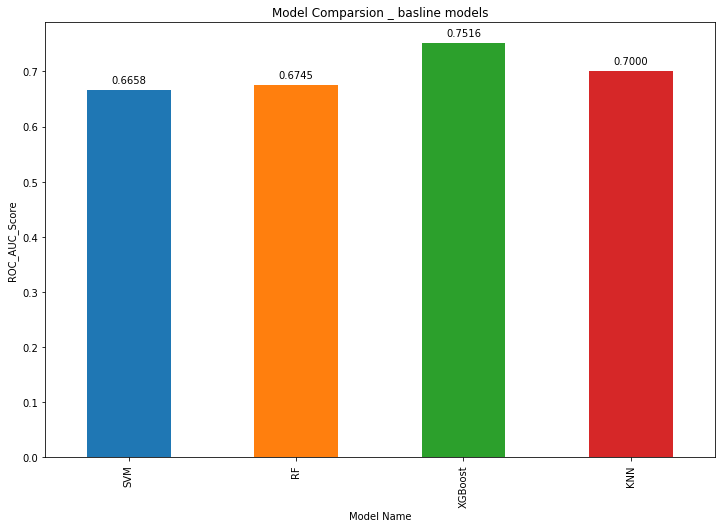

In [33]:
#histogram to compare auc of models
#SVM AUC: 0.6658213006434637
# Random Forest - roc_auc_score:  0.6745548227288356
#XGBoost - roc_auc_score:  0.7516461447594301
#KNN ?? say 0.7


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bring some raw data.
ROC_AUC_Scores = [0.6658, 0.6745, 0.7516, 0.7]

# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
freq_series = pd.Series.from_array(ROC_AUC_Scores)

x_labels = ["SVM","RF","XGBoost","KNN"]

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Model Comparsion _ basline models')
ax.set_xlabel('Model Name')
ax.set_ylabel('ROC_AUC_Score')
ax.set_xticklabels(x_labels)


def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.4f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)